In [1]:
import torch
import numpy as np
from scipy.io import loadmat
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal


In [2]:
from torch.utils.data import TensorDataset, DataLoader

In [3]:
all_data = np.load('processed_data/all_data.npy', allow_pickle=True)[:, 1:, :]
labels = np.load('processed_data/all_labels.npy', allow_pickle=True)
labels = [i-1 for i in labels]
sr = 1000

In [4]:
all_data.shape

(240, 4, 1400)

In [5]:
images = []
for i in range(240):
    time_domain_data = all_data[i,:,:,]
    spectrograms = []
    for j in range(4):
        f, t, Sxx = signal.spectrogram(time_domain_data[j], fs= sr)
        spectrograms.append(Sxx)
    image = np.stack(spectrograms, axis=-1)
    # normalized_image = (image - np.min(image)) / (np.max(image) - np.min(image))  # Corrected line
    images.append(image)
images = np.array(images)

In [6]:
time_domain_data.shape

(4, 1400)

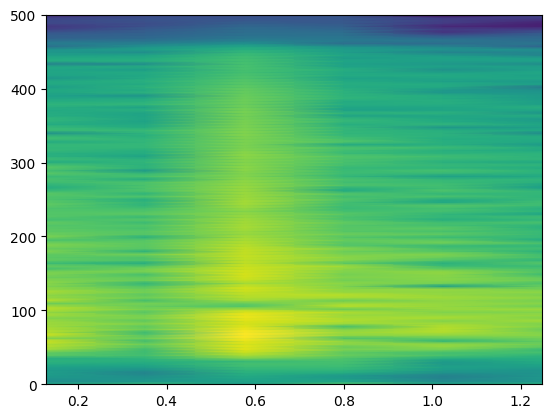

In [7]:
f, t, Sxx = signal.spectrogram(all_data[0,:,:,][1], fs= sr)
plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')

In [8]:
images.shape

(240, 129, 6, 4)

In [9]:
len(labels)

240

In [10]:
images_torch = torch.tensor(images.transpose(0,3,1,2), dtype=torch.float32)
dataset = TensorDataset(images_torch, torch.tensor(labels,dtype=torch.long))
train_set, test_set = torch.utils.data.random_split(dataset, [192, 48])
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

In [11]:
mean = 0.
std = 0.
for images, _ in train_loader:
    batch_samples = images.size(0)  # Batch size (the last batch can have smaller size!)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)

mean /= len(train_loader.dataset)
std /= len(train_loader.dataset)

In [12]:
from torchvision import transforms

# Define the transform
normalize = transforms.Normalize(mean=mean, std=std)

In [13]:
class NormalizedDataset(TensorDataset):
    def __init__(self, *tensors, transform=None):
        super().__init__(*tensors)
        self.transform = transform

    def __getitem__(self, index):
        image, label = super().__getitem__(index)
        if self.transform:
            image = self.transform(image)
        return image, label

# Apply the transform to your training and test datasets
normalized_train_set = NormalizedDataset(*train_set.dataset.tensors, transform=normalize)
normalized_test_set = NormalizedDataset(*test_set.dataset.tensors, transform=normalize)

# Create data loaders for the normalized datasets
train_loader = DataLoader(normalized_train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(normalized_test_set, batch_size=32, shuffle=False)

In [14]:
import torch.nn as nn
import torch.optim as optim


In [15]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

/home/alexiswu/2023Fall/NeuroTech/neurotech/lib/python3.10/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [16]:
class MultiChannelCNN(nn.Module):
    def __init__(self):
        super(MultiChannelCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=4, out_channels=32, kernel_size=(20,2), padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=(10,2), stride=2)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels= 64, kernel_size=(20,2), padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=(10,2), stride=2)

        self.fc1 = nn.Linear(in_features=64*(13)*(2), out_features=500)
        self.relu3 = nn.ReLU()

        self.fc2 = nn.Linear(in_features=500, out_features = 3)

    def forward(self,x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu3(x)
        # pass the output to our softmax classifier to get our output
        # predictions
        x = self.fc2(x)
        # return the output predictions
        return x

In [17]:
model = MultiChannelCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-2)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
lossFn =nn.CrossEntropyLoss()


In [18]:
num_epochs = 150
for epoch in range(num_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        labels = labels.to(device)
        inputs = inputs.to(device)
        optimizer.zero_grad()
        outputs = model(inputs).to(device)
        # _, preds = torch.max(outputs,1)
        loss = lossFn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    # scheduler.step()
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}")

Epoch 1, Loss: 14.084824874997139
Epoch 2, Loss: 1.1126076132059097
Epoch 3, Loss: 1.1311014741659164
Epoch 4, Loss: 1.09284408390522
Epoch 5, Loss: 1.1835150718688965
Epoch 6, Loss: 1.0994127541780472
Epoch 7, Loss: 1.0997042655944824
Epoch 8, Loss: 1.1006857454776764
Epoch 9, Loss: 1.0988676398992538
Epoch 10, Loss: 1.1012182831764221
Epoch 11, Loss: 1.0993124842643738
Epoch 12, Loss: 1.099447801709175
Epoch 13, Loss: 1.1009237319231033
Epoch 14, Loss: 1.0992483794689178
Epoch 15, Loss: 1.1009169667959213
Epoch 16, Loss: 1.1005281209945679
Epoch 17, Loss: 1.1003669202327728
Epoch 18, Loss: 1.099886193871498
Epoch 19, Loss: 1.1000912934541702
Epoch 20, Loss: 1.0994393229484558
Epoch 21, Loss: 1.0988394021987915
Epoch 22, Loss: 1.0992873013019562
Epoch 23, Loss: 1.0995224863290787
Epoch 24, Loss: 1.0993640422821045
Epoch 25, Loss: 1.0991211384534836
Epoch 26, Loss: 1.1002170145511627
Epoch 27, Loss: 1.0991220325231552
Epoch 28, Loss: 1.0988210141658783
Epoch 29, Loss: 1.099730670452118

# Test

In [19]:
all_labels = []
all_preds = []

with torch.no_grad():  # Disable gradient computation
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs,1)
        all_labels.append(labels)
        all_preds.append(preds)

# # Concatenate all the labels and predictions
all_labels = torch.cat(all_labels)
all_preds = torch.cat(all_preds)


In [20]:
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix

# Convert to numpy arrays for use with sklearn
all_labels = all_labels.cpu().numpy()
all_preds = all_preds.cpu().numpy()

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f'Accuracy: {accuracy * 100:.2f}%')

cm = confusion_matrix(all_labels, all_preds)
print(cm)


Accuracy: 33.33%
[[ 0  0 80]
 [ 0  0 80]
 [ 0  0 80]]


In [21]:
df = pd.DataFrame(np.stack([all_labels, all_preds]))

In [22]:
df

,0,1,2,3,4,5,6,7,8,9,...,230,231,232,233,234,235,236,237,238,239
0,0,0,0,2,2,0,2,1,1,2,...,0,2,2,1,2,1,0,2,1,0
1,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2


In [23]:
np.unique(all_preds)

array([2])